<h1>ADVANCED DATA SCIENCE - CAPSTONE PROJECT</h1>
<h2>TITLE : IOT SENSOR MOTION DETECTOR</h2>

In this project, I use the [Environmental Sensor Telemetry Data](https://www.kaggle.com/garystafford/environmental-sensor-data-132k). The objective here is to make data visualization charts in order to understand the dataset and also perform necessary processing in order to prepare the dataset for training on ML models so that we can predict whether a human being is present in the room with the help of the readings of other senors.

<h3>DATASET</h3>

This dataset was obtained from Kaggle. It can be found [here](https://www.kaggle.com/garystafford/environmental-sensor-data-132k).

The dataset originally consists of 405184 rows of customer data and 9 columns. The columns as described from the site are:

- **ts**: Timestamp of event
- **device**: Unique device name 
- **co**: Carbon monoxide level in ppm (%)
- **humidity**: Humidity level (%)
- **light**: Whether light is detected
- **lpg**: LPG level in ppm (%)
- **motion**: Whether motion is detected
- **smoke**: Smoke level in ppm (%) 
- **temp**: Temperature in Farenheit

<h2>DATA EXPLORATION NOTEBOOK</h2>

Let's start by installing **PySpark**.

In [1]:
#Installing PySpark
!pip install pyspark==2.4.5

In [2]:
#Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

Apache Spark requires a *session initialization* before reading the data. Hence, let's create a Spark session. 

In [3]:
#Starting Spark session
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

Now let's download the data from my GitHub repo into the notebook path.

In [4]:
#Obtaining dataset from GitHub
!wget https://github.com/soundarzozm/Iot-Sensor-Data/raw/master/df.parquet?raw=true
!mv df.parquet?raw=true df.parquet

--2020-08-16 17:33:45--  https://github.com/soundarzozm/Iot-Sensor-Data/raw/master/df.parquet?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/soundarzozm/Iot-Sensor-Data/master/df.parquet [following]
--2020-08-16 17:33:46--  https://raw.githubusercontent.com/soundarzozm/Iot-Sensor-Data/master/df.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6169715 (5.9M) [application/octet-stream]
Saving to: ‘df.parquet?raw=true’

100%[======================================>] 6,169,715   --.-K/s   in 0.1s    

2020-08-16 17:33:46 (60.4 MB/s) - ‘df.parquet?raw=true’ saved [6169715/6169715]



Since the dataset is now present in the notebook path, it is time to read the dataset using Apache Spark and create a dataframe instance of the dataset.<br>
Let's name the dataframe as **df** and the dataset as **sensor_data**.

In [5]:
#Reading the dataset as df
df = spark.read.parquet('df.parquet')

#Creating a temporary dataframe instance of the dataset and printing first 20 columns
df.createOrReplaceTempView('sensor_data')
df.show()

+--------------------+-----------------+--------------------+-----------------+-----+--------------------+------+--------------------+------------------+
|                  ts|           device|                  co|         humidity|light|                 lpg|motion|               smoke|              temp|
+--------------------+-----------------+--------------------+-----------------+-----+--------------------+------+--------------------+------------------+
|1.5945120943859744E9|b8:27:eb:bf:9d:51|0.004955938648391245|             51.0|false| 0.00765082227055719| false| 0.02041127012241292|              22.7|
|1.5945120947355676E9|00:0f:00:70:91:0a| 0.00284008860710157|             76.0|false|0.005114383400977071| false|0.013274836704851536|19.700000762939453|
|1.5945120980735726E9|b8:27:eb:bf:9d:51|0.004976012340421658|             50.9|false|0.007673227406398091| false| 0.02047512557617824|              22.6|
|1.5945120995891461E9|1c:bf:ce:15:ec:4d|0.004403026829699689|76.800003051757

Let's check if the **datatypes** of all the columns are appropriate.<br>
This is done by printing the *schema* of the dataframe.

In [6]:
#Print dataframe schema
df.printSchema()

root
 |-- ts: double (nullable = true)
 |-- device: string (nullable = true)
 |-- co: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- light: boolean (nullable = true)
 |-- lpg: double (nullable = true)
 |-- motion: boolean (nullable = true)
 |-- smoke: double (nullable = true)
 |-- temp: double (nullable = true)



Now we can proceed to plotting the **Correlation Matrix**.<br>
<br>
But, for plotting the correlation matrix, we have to first extract the correlation matrix from the dataframe.<br>
This is done by defining a function *correlation_matrix* which takes a spark dataframe as an argument and returns the correlation matrix in the form of a 2-D python list.

In [7]:
#Import necessary libraries
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

#Create label list
labels = ['co', 'humidity', 'light', 'lpg', 'motion', 'smoke', 'temp']

#Define function that accepts a spark dataframe and returns Correlation Matrix 
def correlation_matrix(df):
    
    #Create mew column called corr_features containing necessary features for the matrix
    assembler = VectorAssembler(inputCols=labels, outputCol="corr_features")
    
    #Call the assembler to create an instance
    df_vector = assembler.transform(df).select("corr_features")

    #Get correlation matrix
    matrix = Correlation.corr(df_vector, "corr_features").collect()[0][0]
    
    #Convert to Python list fornat
    cor_mat = matrix.toArray().tolist()
    return cor_mat

print(correlation_matrix(df))

[[1.0, -0.6567501446764338, -0.2301966591379715, 0.9973306253218999, -0.0007058099686227365, 0.9981924231820435, 0.11090496782360153], [-0.6567501446764338, 1.0, 0.0797026395730881, -0.6721128701482547, -0.009826297553428074, -0.6698626403679834, -0.4104271001733614], [-0.2301966591379715, 0.0797026395730881, 1.0, -0.208926242955365, 0.03359398819485161, -0.21296886018125052, 0.7474851114585461], [0.9973306253218999, -0.6721128701482547, -0.208926242955365, 1.0, 0.00023233633739912782, 0.999915870740276, 0.1363960628332268], [-0.0007058099686227365, -0.009826297553428074, 0.03359398819485161, 0.00023233633739912782, 1.0, 6.237751603532496e-05, 0.03764927620930192], [0.9981924231820435, -0.6698626403679834, -0.21296886018125052, 0.999915870740276, 6.237751603532496e-05, 1.0, 0.13189069014169205], [0.11090496782360153, -0.4104271001733614, 0.7474851114585461, 0.1363960628332268, 0.03764927620930192, 0.13189069014169205, 1.0]]


Now that the function is defined, let's test it by creating a dataframe out of the returned python list and printing it.

In [8]:
#Create a dataframe out of the previously obtained Correlation Matrix list and print it
df_cor_mat = spark.createDataFrame(correlation_matrix(df), labels)
df_cor_mat.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|                  co|            humidity|               light|                 lpg|              motion|               smoke|               temp|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+
|                 1.0| -0.6567501446764338| -0.2301966591379715|  0.9973306253218999|-7.05809968622736...|  0.9981924231820435|0.11090496782360153|
| -0.6567501446764338|                 1.0|  0.0797026395730881| -0.6721128701482547|-0.00982629755342...| -0.6698626403679834|-0.4104271001733614|
| -0.2301966591379715|  0.0797026395730881|                 1.0|  -0.208926242955365| 0.03359398819485161|-0.21296886018125052| 0.7474851114585461|
|  0.9973306253218999| -0.6721128701482547|  -0.208926242955365|                 1.0|2.323363373991278...|   0.9

Alright, since everything's perfect, we can proceed to plotting the correlation matrix.<br>
<br>
This is done using **Seaborn** which is a plotting library for Python. We provide the figure size along with title font size.<br>
*Heatmap* refers to the correlation matrix type plot. We provide labels for x, y axes using the *labels* list we defined earlier. We also provide the title text for the plot.

Text(0.5, 1.0, 'Correlation Matrix')

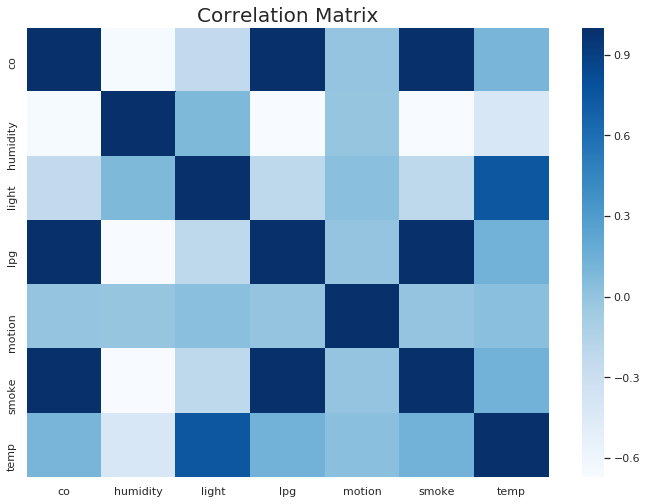

In [9]:
#Plot the Correlation Matrix using Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27), "axes.titlesize":20})
sns.heatmap(correlation_matrix(df), cmap="Blues", xticklabels=labels, yticklabels=labels).set_title('Correlation Matrix')

Now this plot shows how every column/feature is relative to all the other columns/features. In other words, it displays the *correlation* or *covariance*.<br>
Now we can identify columns that are highly correlated to other columns and eliminate either of them since they add redundancy to the dataset.<br>
<br>
Now, we split the dataframe into three different dataframes based on the *device* and examine them individually to gain further insight into the dataset.

In [10]:
#Split dataframes based on the device

df_1 = spark.sql("SELECT * from sensor_data where device = '00:0f:00:70:91:0a'")
df_2 = spark.sql("SELECT * from sensor_data where device = '1c:bf:ce:15:ec:4d'")
df_3 = spark.sql("SELECT * from sensor_data where device = 'b8:27:eb:bf:9d:51'")

Let's print the number of entries in each dataset.

In [11]:
#Print the number of rows in each dataframe
spark.sql("select count(ts) from sensor_data group by device order by device asc").show()

+---------+
|count(ts)|
+---------+
|   111815|
|   105918|
|   187451|
+---------+



Now, let's plot the correlation matrices of all three dataframes one by one.

Text(0.5, 1.0, 'Correlation Matrix\nDevice 1')

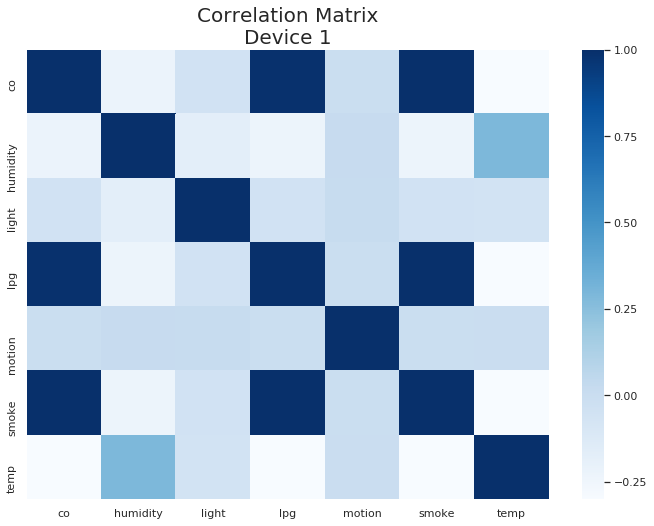

In [12]:
#Plot Correlation Matrix of the first device
sns.set(rc={'figure.figsize':(11.7,8.27), "axes.titlesize":20})
sns.heatmap(correlation_matrix(df_1), cmap="Blues", xticklabels=labels, yticklabels=labels).set_title('Correlation Matrix\nDevice 1')

Text(0.5, 1.0, 'Correlation Matrix\nDevice 2')

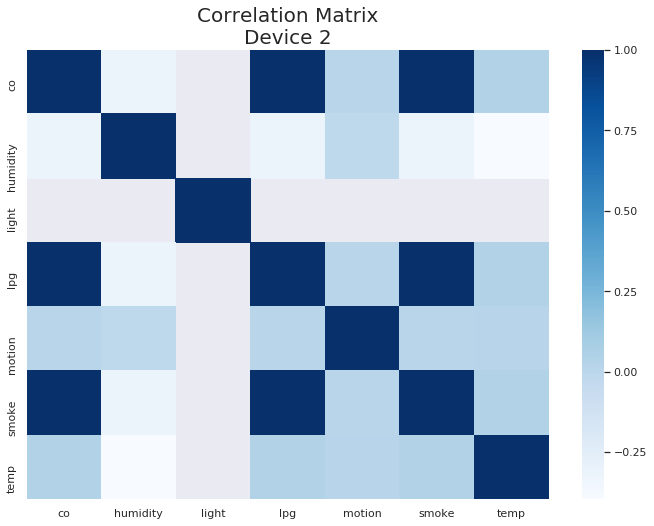

In [13]:
#Plot Correlation Matrix of the second device
sns.set(rc={'figure.figsize':(11.7,8.27), "axes.titlesize":20})
sns.heatmap(correlation_matrix(df_2), cmap="Blues", xticklabels=labels, yticklabels=labels).set_title('Correlation Matrix\nDevice 2')

Text(0.5, 1.0, 'Correlation Matrix\nDevice 3')

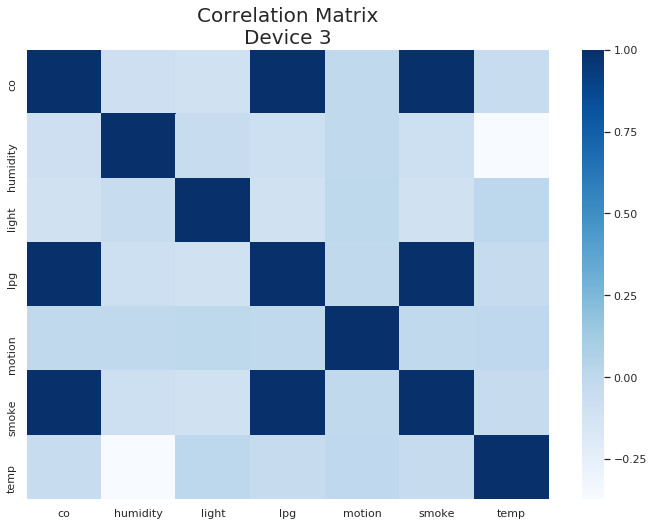

In [14]:
#Plot Correlation Matrix of the third device
sns.set(rc={'figure.figsize':(11.7,8.27), "axes.titlesize":20})
sns.heatmap(correlation_matrix(df_3), cmap="Blues", xticklabels=labels, yticklabels=labels).set_title('Correlation Matrix\nDevice 3')

We can observe that the correlation matrix of 'Device 3' has favourable entries since the correlation is <0.25 for all features uniformly except for **Smoke vs LPG vs CO**.<br>
This insists that the readings of Smoke, LPG and CO are highly correlated and redundant. Hence, we can eliminate any two of these features.<br>
<br>
Now, let's plot the values of **each feature against Timestamp** to analyse how the readings vary with time device-to-device.

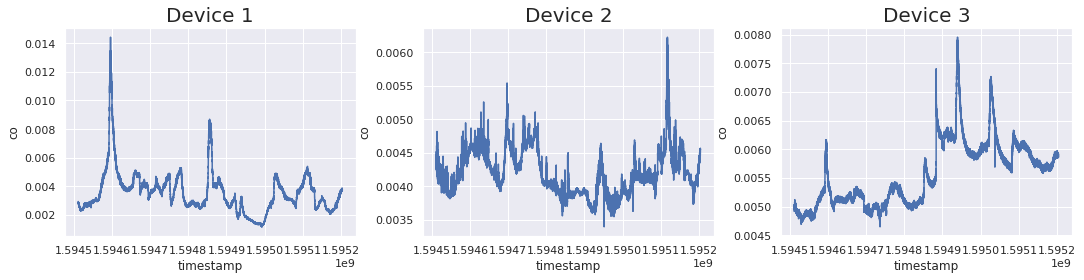

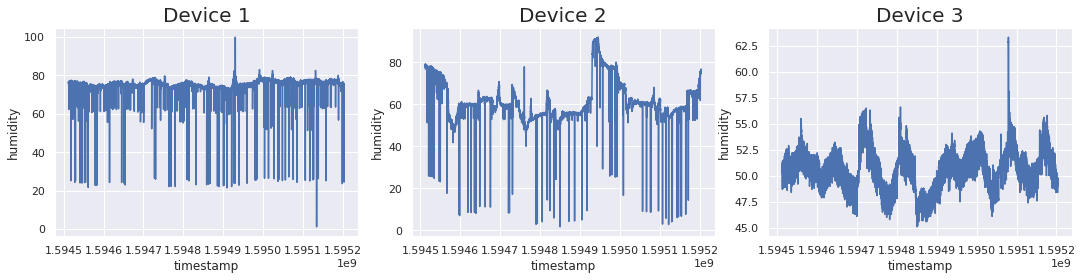

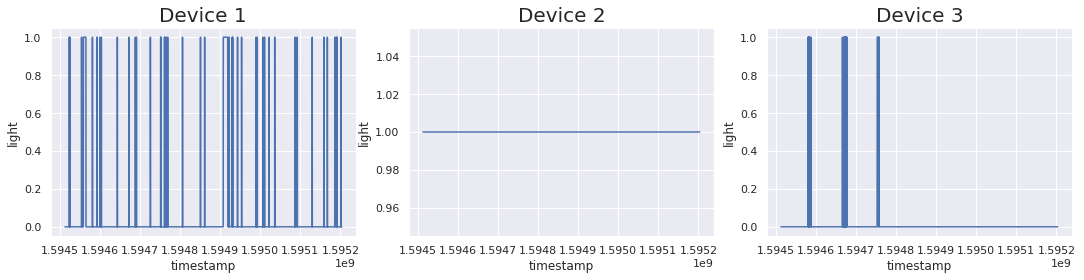

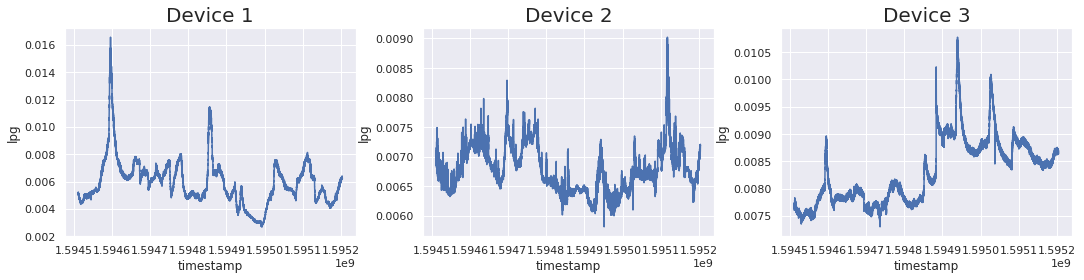

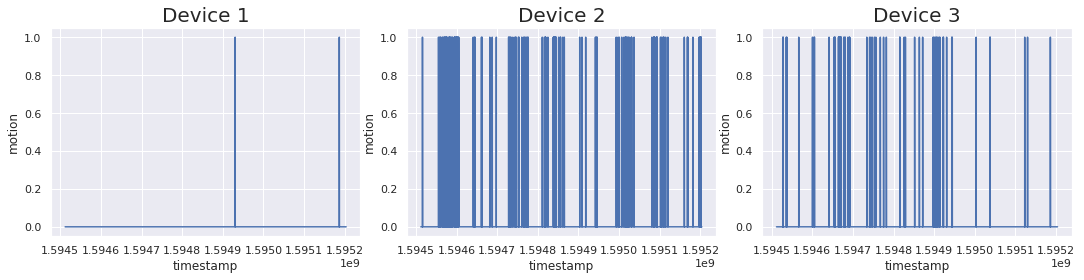

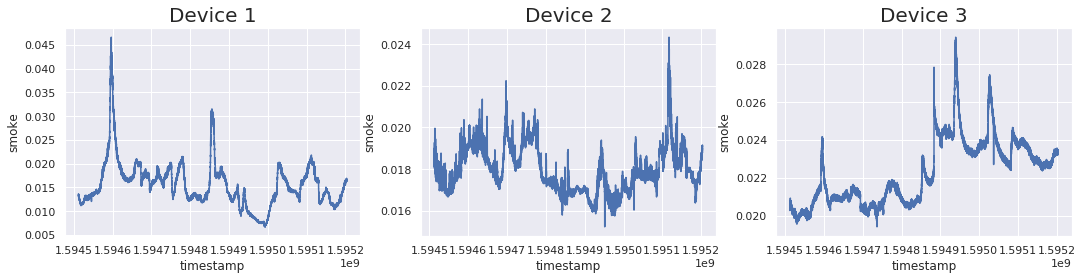

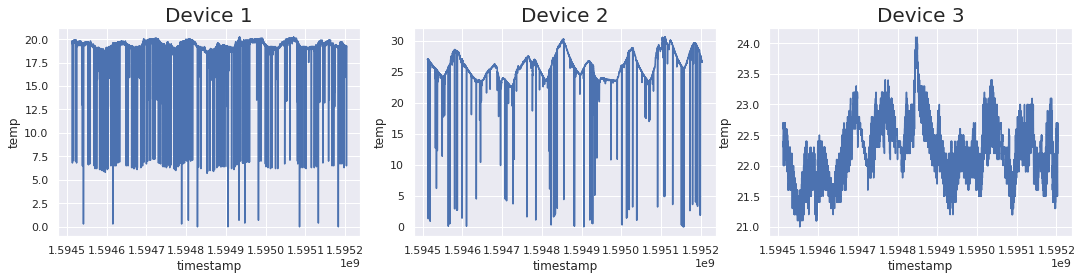

In [15]:
#Plot each feature against Timestamp to analyse the readings device-wise
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27), "axes.titlesize":20})

def draw_plots(i):    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    axes[0].plot(df_1.select(df_1[0]).rdd.flatMap(lambda x: x).collect(), df_1.select(df_1[i]).rdd.flatMap(lambda x: x).collect())
    axes[0].set_title('Device 1')

    axes[1].plot(df_2.select(df_2[0]).rdd.flatMap(lambda x: x).collect(), df_2.select(df_2[i]).rdd.flatMap(lambda x: x).collect())
    axes[1].set_title('Device 2')

    axes[2].plot(df_3.select(df_3[0]).rdd.flatMap(lambda x: x).collect(), df_3.select(df_3[i]).rdd.flatMap(lambda x: x).collect())
    axes[2].set_title('Device 3')

    fig.tight_layout()

    for ax in axes.flat:
        ax.set(xlabel='timestamp', ylabel=labels[i-2])
        
for i in range(2,9):
    draw_plots(i)  

We notice that the graphs of **CO, Smoke and LPG** are highly identical. This supports the hypothesis made earlier by reading the correlation matrix, which confirms that they are highly correlated to each other.<br>
It does make sense logically as well, because smoke consists of gasses like CO and LPG. Hence, we can safely eliminate CO and LPG from the dataframe.<br>
<br>
But, we can also notice another issue - the light vs ts plot for Device 2 has no *True* values! This suggests that the light sensor of the second device might be broken. Hence we really cannot use the dataframe for Machine Learning model training. Hence we *eliminate* the second dataframe.<br><br>
Now, let's dive a bit more deeper into the hypothesis we made by plotting Smoke, CO and LPG against each other to obtain the relationship they have.

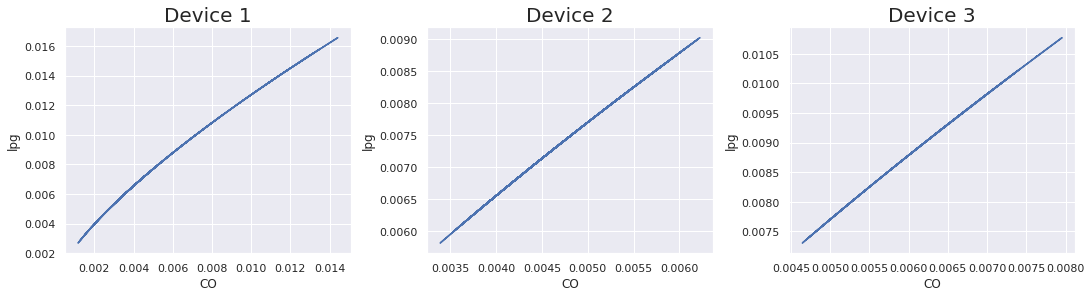

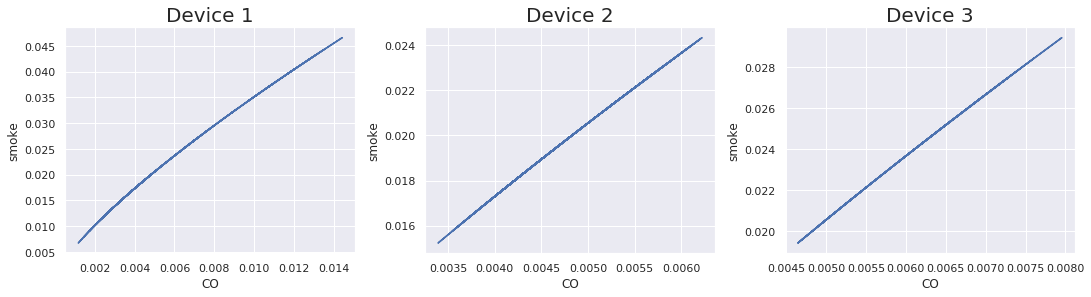

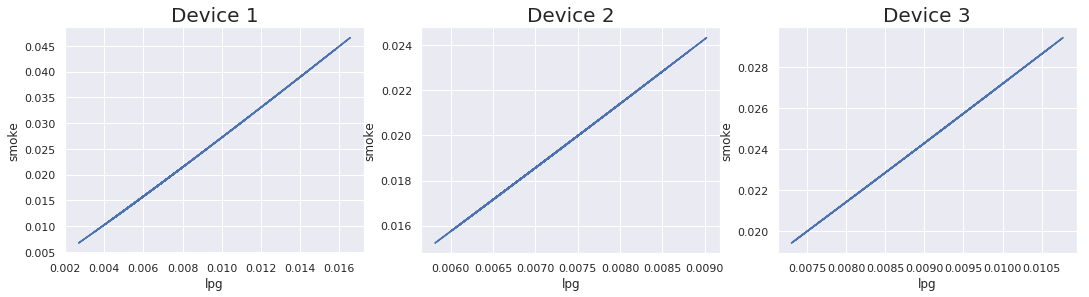

In [16]:
#Plot graphs for Smoke, CO, and LPG against each other to analyse dependency
%matplotlib inline

comp_labels = [5,7]

def draw_comparison(i):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    axes[0].plot(df_1.select(df_1[2]).rdd.flatMap(lambda x: x).collect(), df_1.select(df_1[i]).rdd.flatMap(lambda x: x).collect())
    axes[0].set_title('Device 1')

    axes[1].plot(df_2.select(df_2[2]).rdd.flatMap(lambda x: x).collect(), df_2.select(df_2[i]).rdd.flatMap(lambda x: x).collect())
    axes[1].set_title('Device 2')

    axes[2].plot(df_3.select(df_3[2]).rdd.flatMap(lambda x: x).collect(), df_3.select(df_3[i]).rdd.flatMap(lambda x: x).collect())
    axes[2].set_title('Device 3')

    fig.tight_layout()

    for ax in axes.flat:
        ax.set(xlabel='CO', ylabel=str(df.columns[i]))
        
for i in comp_labels:
    draw_comparison(i)
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

axes[0].plot(df_1.select('lpg').rdd.flatMap(lambda x: x).collect(), df_1.select('smoke').rdd.flatMap(lambda x: x).collect())
axes[0].set_title('Device 1')

axes[1].plot(df_2.select('lpg').rdd.flatMap(lambda x: x).collect(), df_2.select('smoke').rdd.flatMap(lambda x: x).collect())
axes[1].set_title('Device 2')

axes[2].plot(df_3.select('lpg').rdd.flatMap(lambda x: x).collect(), df_3.select('smoke').rdd.flatMap(lambda x: x).collect())
axes[2].set_title('Device 3')

fig.tight_layout()

for ax in axes.flat:
    ax.set(xlabel='lpg', ylabel='smoke')  

Now, we observe that all the graphs are very linear. This suggests they have a very linear relationship i.e. they are highly correlated.<br>
<br>
Let's print the statistical description of all three devices to check for outliers and abnormal records.

In [17]:
#Print statistical description of device 1
df_1.describe().show()

+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|                  ts|           device|                  co|          humidity|                 lpg|               smoke|              temp|
+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|              111815|           111815|              111815|            111815|              111815|              111815|            111815|
|   mean|1.5948592999335306E9|             null|0.003526849627149...| 75.44436079832734|0.005893469356955367|0.015488986849308092| 19.36255246911829|
| stddev|   199860.9568699501|             null|0.001478652502346...|1.9758011748642834|0.001699825319151...| 0.00480926894393379|0.6437864157397418|
|    min|1.5945120947355676E9|00:0f:00:70:91:0a|0.001170508548437...| 1.100000023841858|0.0026934786

In [18]:
#Print statistical description of device 2
df_2.describe().show()

+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|                  ts|           device|                  co|          humidity|                 lpg|               smoke|              temp|
+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|              105918|           105918|              105918|            105918|              105918|              105918|            105918|
|   mean|1.5948571214450426E9|             null|0.004182889964652226| 61.91024663855242|0.006763612076770993|0.017895283862884047|26.025511285357403|
| stddev|  198977.18403306563|             null|3.204083596352242...|  8.94479224243666|3.730355025865785E-4|0.001055149706445...|2.0264270412932013|
|    min|1.5945120995891461E9|1c:bf:ce:15:ec:4d| 0.00339108912523602|1.6000000238418581|0.0058143437

In [19]:
#Print statistical description of device 3
df_3.describe().show()

+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|                  ts|           device|                  co|          humidity|                 lpg|               smoke|              temp|
+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|              187451|           187451|              187451|            187451|              187451|              187451|            187451|
|   mean| 1.594857758396128E9|             null|0.005559786789554086| 50.81407674538176|0.008306175914361837|0.022288350217858362|22.279969165276523|
| stddev|  199573.34655085154|             null|5.587085001411119E-4|1.8889262809920346|5.993221940873393E-4|0.001720104166737...|0.4819022291417346|
|    min|1.5945120943859744E9|b8:27:eb:bf:9d:51|0.004645561212400...|              45.1|0.0073011173

We notice that there are no extreme outliers and hence assume safely that the data is not faulty.<br>
<br>
We can obtain further clarity by plotting **boxplots** which provide this statistical data graphically for easier analysis.<br>
Check this [website](https://www.simplypsychology.org/boxplots.html#:~:text=What%20is%20a%20box%20plot,(or%20percentiles)%20and%20averages) to gain knowledge about reading boxplots.

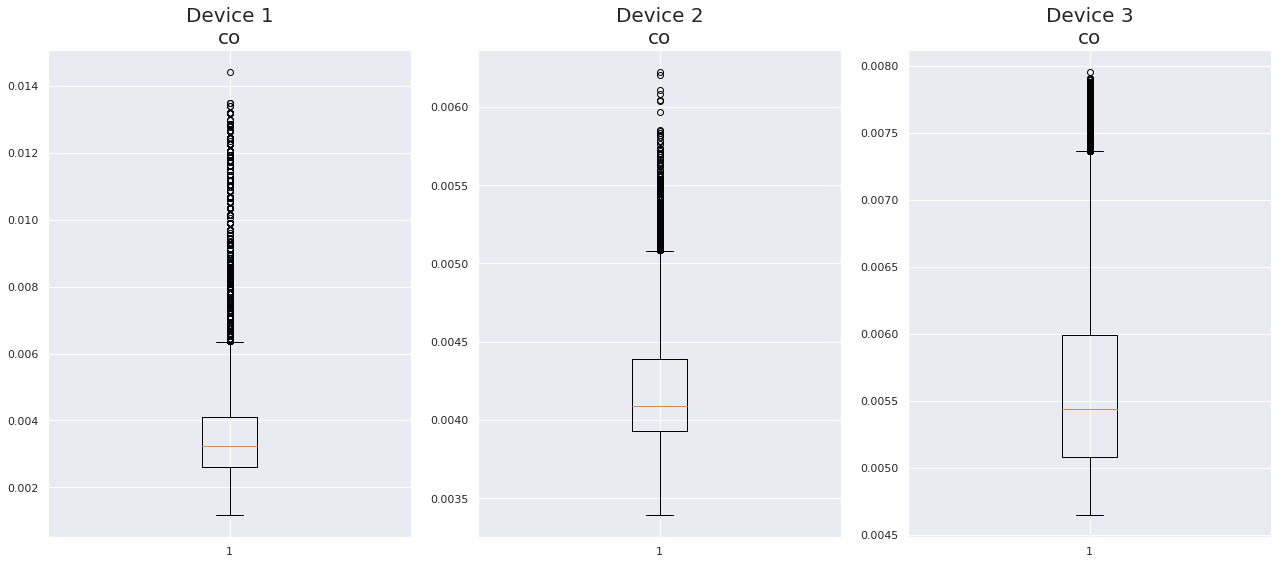

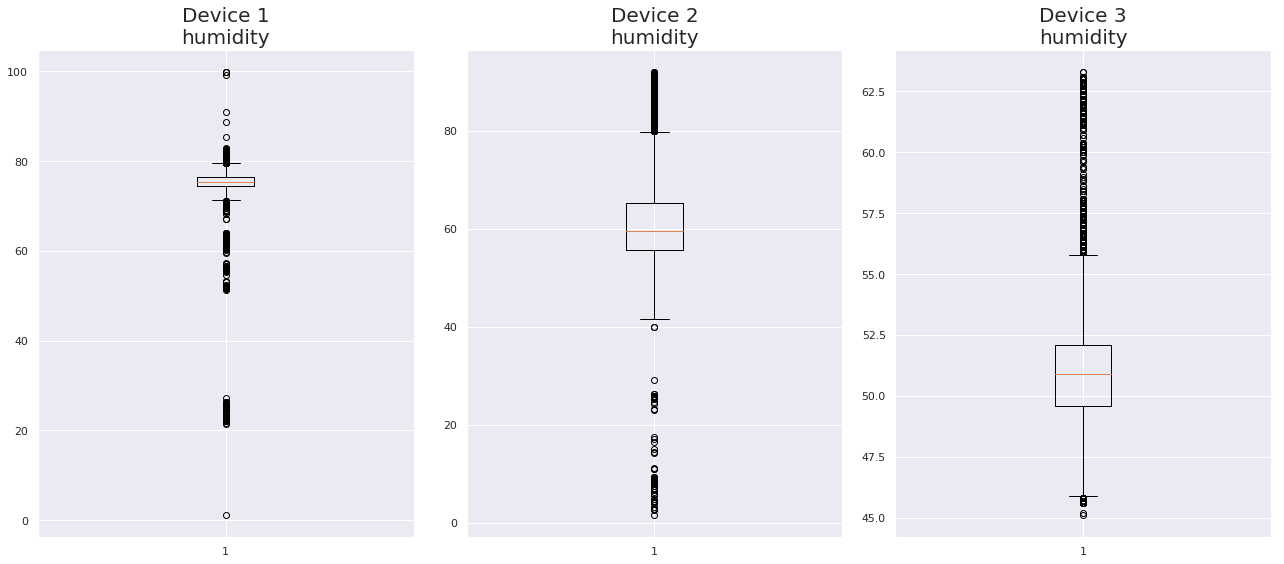

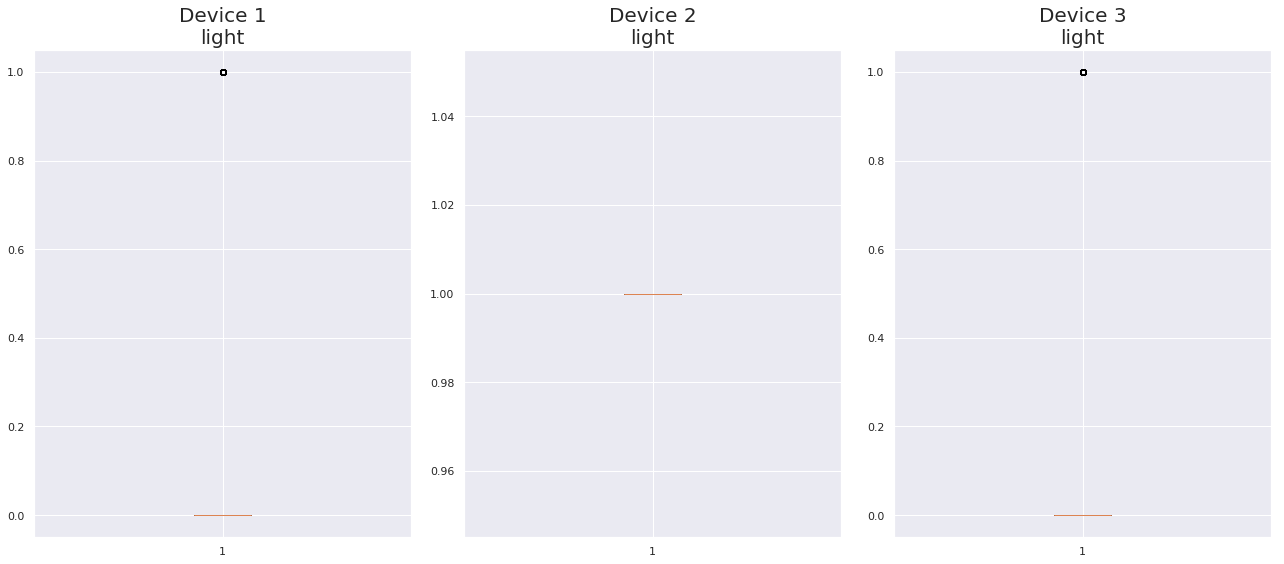

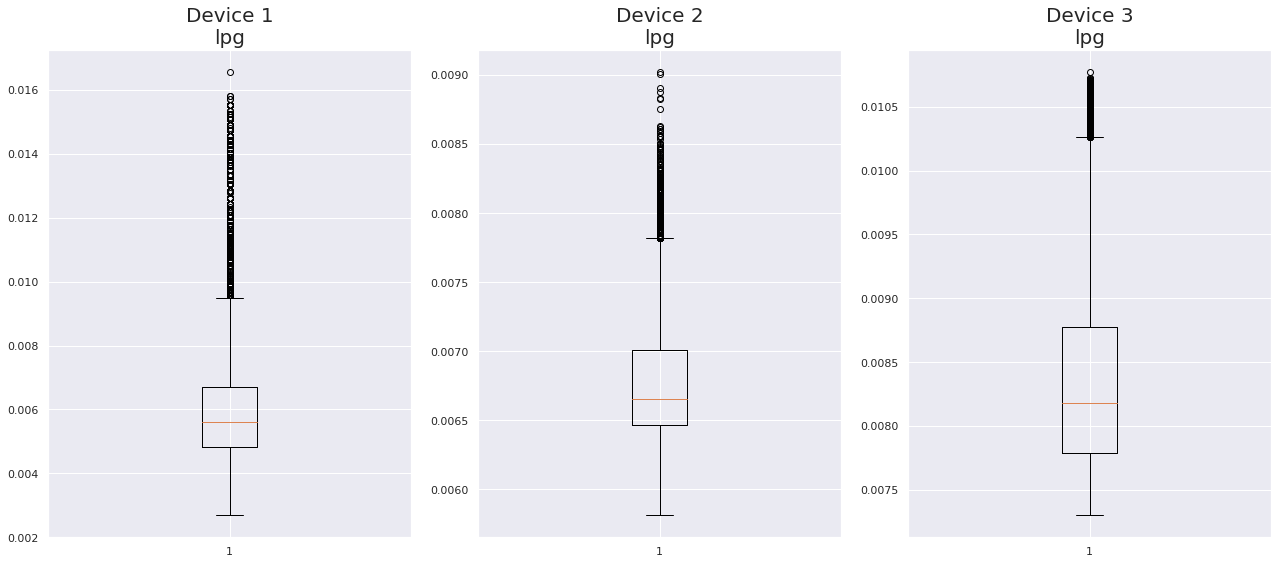

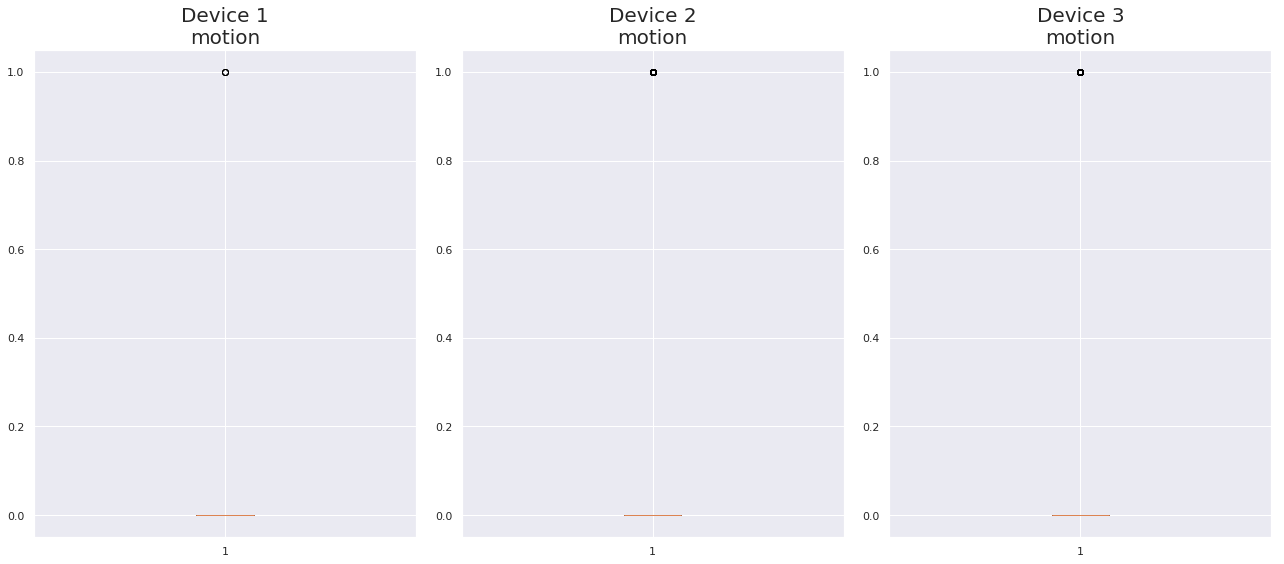

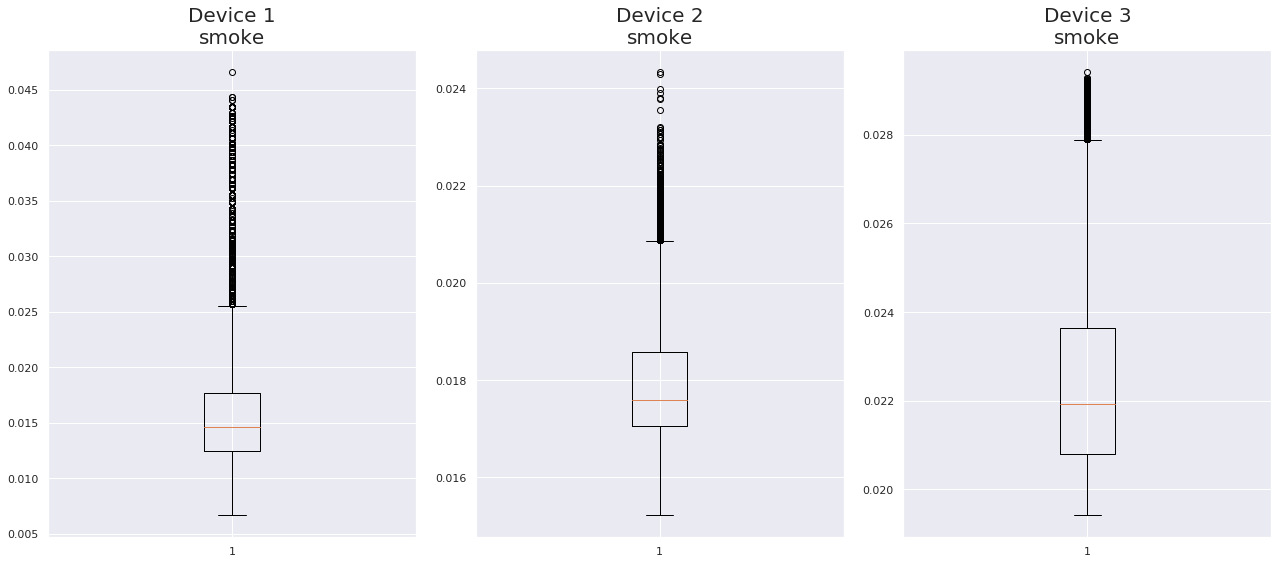

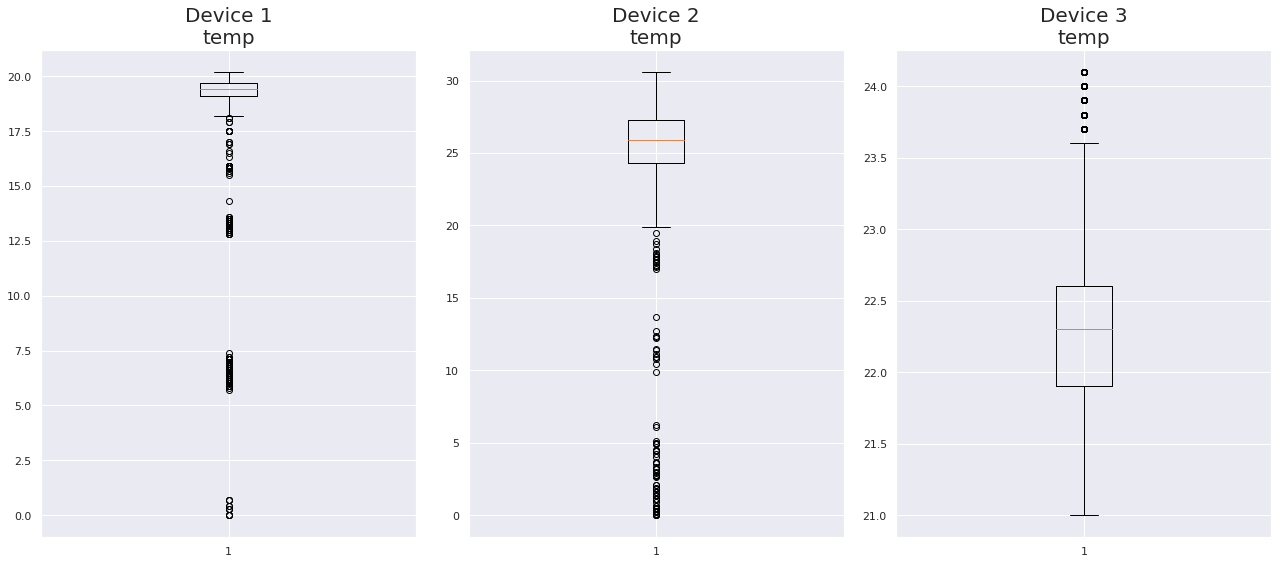

In [20]:
#Plot Box-plots to analyse the readings device-wise
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27), "axes.titlesize":20})

def draw_plots(i):    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

    axes[0].boxplot(df_1.select(df_1[i]).rdd.flatMap(lambda x: x).collect())
    axes[0].set_title('Device 1\n'+labels[i-2])

    axes[1].boxplot(df_2.select(df_2[i]).rdd.flatMap(lambda x: x).collect())
    axes[1].set_title('Device 2\n'+labels[i-2])

    axes[2].boxplot(df_3.select(df_3[i]).rdd.flatMap(lambda x: x).collect())
    axes[2].set_title('Device 3\n'+labels[i-2])

    fig.tight_layout()


for i in range(2,9):
    draw_plots(i) 